# 02 - Data Cleaning and Preprocessing

This notebook cleans and preprocesses the MovieLens data for modeling:
- Filter users with minimum rating count
- Filter movies with minimum rating count
- Remove outliers and low-quality data
- Convert to efficient parquet format
- Generate processed dataset for training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Paths

In [2]:
# Load project config
project_root = Path.cwd().parent
config_path = project_root / 'config' / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Data paths
raw_dir = project_root / config['data']['raw_dir'] / 'ml-25m'
processed_dir = project_root / config['data']['processed_dir']
processed_dir.mkdir(parents=True, exist_ok=True)

# Cleaning parameters from config
MIN_USER_RATINGS = config['cleaning']['min_user_ratings']
MIN_MOVIE_RATINGS = config['cleaning']['min_movie_ratings']
OUTLIER_THRESHOLD = config['cleaning']['outlier_threshold']

print(f"Raw data directory: {raw_dir}")
print(f"Processed data directory: {processed_dir}")
print(f"\nCleaning parameters:")
print(f"  Min user ratings: {MIN_USER_RATINGS}")
print(f"  Min movie ratings: {MIN_MOVIE_RATINGS}")
print(f"  Outlier threshold: {OUTLIER_THRESHOLD}")

Raw data directory: c:\Users\ololi\StudioProjects\movie-recommender\data\raw\ml-25m
Processed data directory: c:\Users\ololi\StudioProjects\movie-recommender\data\processed

Cleaning parameters:
  Min user ratings: 20
  Min movie ratings: 5
  Outlier threshold: 0.95


## 2. Load Raw Data

In [3]:
# Load ratings
print("Loading raw data...")
ratings = pd.read_csv(raw_dir / 'ratings.csv')
movies = pd.read_csv(raw_dir / 'movies.csv')
links = pd.read_csv(raw_dir / 'links.csv')
tags = pd.read_csv(raw_dir / 'tags.csv')

print(f"\nOriginal dataset size:")
print(f"  Ratings: {len(ratings):,}")
print(f"  Users: {ratings['userId'].nunique():,}")
print(f"  Movies: {ratings['movieId'].nunique():,}")
print(f"  Movie catalog: {len(movies):,}")
print(f"  Tags: {len(tags):,}")

Loading raw data...

Original dataset size:
  Ratings: 25,000,095
  Users: 162,541
  Movies: 59,047
  Movie catalog: 62,423
  Tags: 1,093,360


## 3. Initial Data Cleaning

In [4]:
print("Step 1: Initial cleaning...")

# Remove duplicates (if any)
before = len(ratings)
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'], keep='last')
after = len(ratings)
print(f"  Removed {before - after:,} duplicate ratings")

# Verify rating range
invalid_ratings = ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)]
print(f"  Invalid ratings found: {len(invalid_ratings)}")
if len(invalid_ratings) > 0:
    ratings = ratings[(ratings['rating'] >= 0.5) & (ratings['rating'] <= 5.0)]
    print(f"  Removed {len(invalid_ratings)} invalid ratings")

# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

print(f"\nAfter initial cleaning: {len(ratings):,} ratings")

Step 1: Initial cleaning...
  Removed 0 duplicate ratings
  Invalid ratings found: 0

After initial cleaning: 25,000,095 ratings


## 4. Filter Movies (Minimum Rating Count)

In [5]:
print(f"Step 2: Filter movies with < {MIN_MOVIE_RATINGS} ratings...")

# Count ratings per movie
movie_counts = ratings.groupby('movieId').size()

# Movies to keep
valid_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index

print(f"  Movies before: {len(movie_counts):,}")
print(f"  Movies after: {len(valid_movies):,}")
print(f"  Removed: {len(movie_counts) - len(valid_movies):,} movies")

# Filter ratings
before = len(ratings)
ratings = ratings[ratings['movieId'].isin(valid_movies)]
after = len(ratings)

print(f"\n  Ratings before: {before:,}")
print(f"  Ratings after: {after:,}")
print(f"  Removed: {before - after:,} ratings ({(before-after)/before*100:.1f}%)")

Step 2: Filter movies with < 5 ratings...
  Movies before: 59,047
  Movies after: 32,720
  Removed: 26,327 movies

  Ratings before: 25,000,095
  Ratings after: 24,945,870
  Removed: 54,225 ratings (0.2%)


## 5. Filter Users (Minimum Rating Count)

In [6]:
print(f"Step 3: Filter users with < {MIN_USER_RATINGS} ratings...")

# Count ratings per user
user_counts = ratings.groupby('userId').size()

# Users to keep
valid_users = user_counts[user_counts >= MIN_USER_RATINGS].index

print(f"  Users before: {len(user_counts):,}")
print(f"  Users after: {len(valid_users):,}")
print(f"  Removed: {len(user_counts) - len(valid_users):,} users")

# Filter ratings
before = len(ratings)
ratings = ratings[ratings['userId'].isin(valid_users)]
after = len(ratings)

print(f"\n  Ratings before: {before:,}")
print(f"  Ratings after: {after:,}")
print(f"  Removed: {before - after:,} ratings ({(before-after)/before*100:.1f}%)")

Step 3: Filter users with < 20 ratings...
  Users before: 162,541
  Users after: 162,516
  Removed: 25 users

  Ratings before: 24,945,870
  Ratings after: 24,945,426
  Removed: 444 ratings (0.0%)


## 6. Remove Outlier Users

In [9]:
from tqdm import tqdm

print(f"Step 4: Remove outlier users (>{OUTLIER_THRESHOLD*100:.0f}% same rating)...")

# Calculate rating variance per user
user_rating_variance = ratings.groupby('userId')['rating'].agg(['std', 'count'])

# Find users with very low variance (mostly same rating)
# Check what percentage of their ratings are the same
user_mode_freq = []
unique_users = ratings['userId'].unique()

for user_id in tqdm(unique_users, desc="Analyzing users"):
    user_ratings = ratings[ratings['userId'] == user_id]['rating']
    mode_count = user_ratings.mode()[0] if len(user_ratings.mode()) > 0 else 0
    mode_freq = (user_ratings == user_ratings.mode()[0]).sum() / len(user_ratings)
    user_mode_freq.append({'userId': user_id, 'mode_freq': mode_freq, 'count': len(user_ratings)})

user_mode_df = pd.DataFrame(user_mode_freq)

# Remove users with >OUTLIER_THRESHOLD same rating
outlier_users = user_mode_df[user_mode_df['mode_freq'] > OUTLIER_THRESHOLD]['userId']

print(f"  Outlier users found: {len(outlier_users):,}")

before = len(ratings)
ratings = ratings[~ratings['userId'].isin(outlier_users)]
after = len(ratings)

print(f"  Removed: {before - after:,} ratings from outlier users")

Step 4: Remove outlier users (>95% same rating)...


Analyzing users: 100%|██████████| 162516/162516 [29:55<00:00, 90.49it/s]


  Outlier users found: 403
  Removed: 29,415 ratings from outlier users


## 7. Iterative Cleaning (Re-filter After Removals)

In [10]:
print("Step 5: Iterative cleaning...")
print("After removing users/movies, some movies/users may now have too few ratings.")
print("Re-applying filters...\n")

iteration = 0
max_iterations = 5
prev_size = len(ratings)

while iteration < max_iterations:
    iteration += 1
    print(f"Iteration {iteration}:")

    # Filter movies
    movie_counts = ratings.groupby('movieId').size()
    valid_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index
    ratings = ratings[ratings['movieId'].isin(valid_movies)]

    # Filter users
    user_counts = ratings.groupby('userId').size()
    valid_users = user_counts[user_counts >= MIN_USER_RATINGS].index
    ratings = ratings[ratings['userId'].isin(valid_users)]

    current_size = len(ratings)
    removed = prev_size - current_size

    print(f"  Ratings: {current_size:,} (removed {removed:,})")

    # Stop if no change
    if removed == 0:
        print("  ✓ No more changes, cleaning complete!")
        break

    prev_size = current_size

if iteration == max_iterations:
    print(f"\n⚠ Reached max iterations ({max_iterations})")

Step 5: Iterative cleaning...
After removing users/movies, some movies/users may now have too few ratings.
Re-applying filters...

Iteration 1:
  Ratings: 24,914,810 (removed 1,201)
Iteration 2:
  Ratings: 24,914,810 (removed 0)
  ✓ No more changes, cleaning complete!


## 8. Clean Movie Metadata

In [11]:
print("Step 6: Clean movie metadata...")

# Keep only movies that are in cleaned ratings
rated_movie_ids = ratings['movieId'].unique()
movies_clean = movies[movies['movieId'].isin(rated_movie_ids)].copy()

print(f"  Movies in catalog before: {len(movies):,}")
print(f"  Movies in catalog after: {len(movies_clean):,}")

# Clean movie titles (extract year if in format "Title (Year)")
import re

def extract_year(title):
    """Extract year from movie title."""
    match = re.search(r'\((\d{4})\)\s*$', title)
    return int(match.group(1)) if match else None

def clean_title(title):
    """Remove year from title."""
    return re.sub(r'\s*\(\d{4}\)\s*$', '', title).strip()

movies_clean['year'] = movies_clean['title'].apply(extract_year)
movies_clean['title_clean'] = movies_clean['title'].apply(clean_title)

print(f"  Movies with year extracted: {movies_clean['year'].notna().sum():,}")

# Clean links
links_clean = links[links['movieId'].isin(rated_movie_ids)].copy()
print(f"\n  Links before: {len(links):,}")
print(f"  Links after: {len(links_clean):,}")

# Clean tags
tags_clean = tags[tags['movieId'].isin(rated_movie_ids)].copy()
print(f"\n  Tags before: {len(tags):,}")
print(f"  Tags after: {len(tags_clean):,}")

Step 6: Clean movie metadata...
  Movies in catalog before: 62,423
  Movies in catalog after: 32,424
  Movies with year extracted: 32,336

  Links before: 62,423
  Links after: 32,424

  Tags before: 1,093,360
  Tags after: 1,034,097


## 9. Final Dataset Statistics

In [12]:
print("=" * 60)
print("CLEANED DATASET STATISTICS")
print("=" * 60)

n_ratings = len(ratings)
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()

print(f"\nSize:")
print(f"  Ratings: {n_ratings:,}")
print(f"  Users: {n_users:,}")
print(f"  Movies: {n_movies:,}")

# Sparsity
sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"\nMatrix Sparsity: {sparsity:.2%}")
print(f"Matrix Density: {(1-sparsity):.4%}")

# Ratings per user/movie
user_counts = ratings.groupby('userId').size()
movie_counts = ratings.groupby('movieId').size()

print(f"\nRatings per User:")
print(f"  Mean: {user_counts.mean():.1f}")
print(f"  Median: {user_counts.median():.0f}")
print(f"  Min: {user_counts.min()}")
print(f"  Max: {user_counts.max()}")

print(f"\nRatings per Movie:")
print(f"  Mean: {movie_counts.mean():.1f}")
print(f"  Median: {movie_counts.median():.0f}")
print(f"  Min: {movie_counts.min()}")
print(f"  Max: {movie_counts.max()}")

print(f"\nRating Distribution:")
print(f"  Mean: {ratings['rating'].mean():.2f}")
print(f"  Median: {ratings['rating'].median():.1f}")
print(f"  Std: {ratings['rating'].std():.2f}")

print("\n" + "=" * 60)

CLEANED DATASET STATISTICS

Size:
  Ratings: 24,914,810
  Users: 162,112
  Movies: 32,424

Matrix Sparsity: 99.53%
Matrix Density: 0.4740%

Ratings per User:
  Mean: 153.7
  Median: 71
  Min: 20
  Max: 22213

Ratings per Movie:
  Mean: 768.4
  Median: 28
  Min: 5
  Max: 81394

Rating Distribution:
  Mean: 3.53
  Median: 3.5
  Std: 1.06



## 10. Visualize Cleaned Data

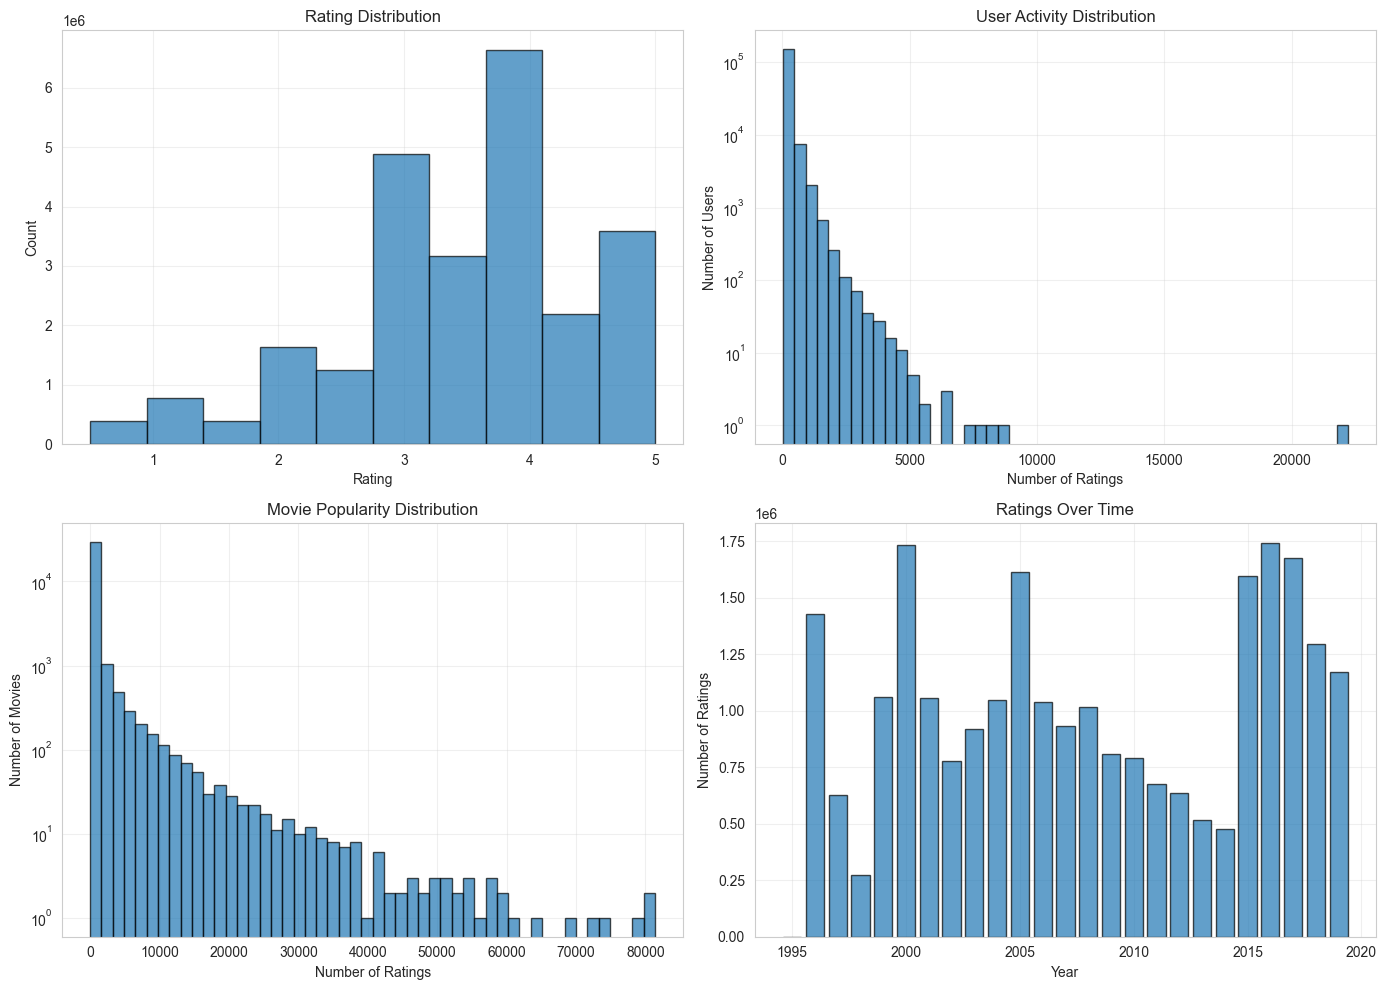

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rating distribution
axes[0, 0].hist(ratings['rating'], bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].grid(True, alpha=0.3)

# User activity
axes[0, 1].hist(user_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Movie popularity
axes[1, 0].hist(movie_counts, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_title('Movie Popularity Distribution')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Ratings over time
ratings_by_year = ratings.groupby(ratings['datetime'].dt.year).size()
axes[1, 1].bar(ratings_by_year.index, ratings_by_year.values, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Ratings')
axes[1, 1].set_title('Ratings Over Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Save Cleaned Data

In [14]:
print("Saving cleaned data to parquet format...\n")

# Prepare ratings for export (select relevant columns)
ratings_export = ratings[['userId', 'movieId', 'rating', 'timestamp', 'datetime']].copy()

# Save ratings
ratings_path = processed_dir / 'ratings_cleaned.parquet'
ratings_export.to_parquet(ratings_path, index=False, compression='snappy')
print(f"✓ Saved ratings to: {ratings_path}")
print(f"  Size: {ratings_path.stat().st_size / 1024**2:.1f} MB")

# Save movies
movies_path = processed_dir / 'movies_cleaned.parquet'
movies_clean.to_parquet(movies_path, index=False, compression='snappy')
print(f"\n✓ Saved movies to: {movies_path}")
print(f"  Size: {movies_path.stat().st_size / 1024**2:.1f} MB")

# Save links
links_path = processed_dir / 'links_cleaned.parquet'
links_clean.to_parquet(links_path, index=False, compression='snappy')
print(f"\n✓ Saved links to: {links_path}")
print(f"  Size: {links_path.stat().st_size / 1024**2:.1f} MB")

# Save tags
tags_path = processed_dir / 'tags_cleaned.parquet'
tags_clean.to_parquet(tags_path, index=False, compression='snappy')
print(f"\n✓ Saved tags to: {tags_path}")
print(f"  Size: {tags_path.stat().st_size / 1024**2:.1f} MB")

print("\n" + "=" * 60)
print("✓ ALL DATA SAVED SUCCESSFULLY!")
print("=" * 60)

Saving cleaned data to parquet format...

✓ Saved ratings to: c:\Users\ololi\StudioProjects\movie-recommender\data\processed\ratings_cleaned.parquet
  Size: 313.5 MB

✓ Saved movies to: c:\Users\ololi\StudioProjects\movie-recommender\data\processed\movies_cleaned.parquet
  Size: 1.5 MB

✓ Saved links to: c:\Users\ololi\StudioProjects\movie-recommender\data\processed\links_cleaned.parquet
  Size: 0.6 MB

✓ Saved tags to: c:\Users\ololi\StudioProjects\movie-recommender\data\processed\tags_cleaned.parquet
  Size: 9.8 MB

✓ ALL DATA SAVED SUCCESSFULLY!


## 12. Generate Summary Report

In [15]:
# Create summary report
summary = {
    'cleaning_timestamp': pd.Timestamp.now().isoformat(),
    'original': {
        'ratings': len(pd.read_csv(raw_dir / 'ratings.csv')),
        'users': pd.read_csv(raw_dir / 'ratings.csv')['userId'].nunique(),
        'movies': len(pd.read_csv(raw_dir / 'movies.csv'))
    },
    'cleaned': {
        'ratings': n_ratings,
        'users': n_users,
        'movies': n_movies
    },
    'statistics': {
        'sparsity': float(sparsity),
        'avg_rating': float(ratings['rating'].mean()),
        'avg_ratings_per_user': float(user_counts.mean()),
        'avg_ratings_per_movie': float(movie_counts.mean()),
        'median_ratings_per_user': int(user_counts.median()),
        'median_ratings_per_movie': int(movie_counts.median())
    },
    'config': {
        'min_user_ratings': MIN_USER_RATINGS,
        'min_movie_ratings': MIN_MOVIE_RATINGS,
        'outlier_threshold': OUTLIER_THRESHOLD
    }
}

# Save summary
summary_path = processed_dir / 'cleaning_summary.yaml'
with open(summary_path, 'w') as f:
    yaml.dump(summary, f, default_flow_style=False)

print(f"✓ Summary saved to: {summary_path}")
print("\nSummary:")
print(yaml.dump(summary, default_flow_style=False))

✓ Summary saved to: c:\Users\ololi\StudioProjects\movie-recommender\data\processed\cleaning_summary.yaml

Summary:
cleaned:
  movies: 32424
  ratings: 24914810
  users: 162112
cleaning_timestamp: '2026-02-17T21:44:08.193731'
config:
  min_movie_ratings: 5
  min_user_ratings: 20
  outlier_threshold: 0.95
original:
  movies: 62423
  ratings: 25000095
  users: 162541
statistics:
  avg_rating: 3.533641316148909
  avg_ratings_per_movie: 768.4064273377745
  avg_ratings_per_user: 153.68886942360837
  median_ratings_per_movie: 28
  median_ratings_per_user: 71
  sparsity: 0.99526002746658

